In [3]:
import numpy as np

batch_1 = np.load("all_sims_data_batch_0.npy")
batch_2 = np.load("all_sims_data_batch_1.npy")
batch_3 = np.load("all_sims_data_batch_2.npy")

# Concatenating along axis 0 (commonly used for stacking batches)
final_batch = np.concatenate([batch_1, batch_2, batch_3], axis=0)

np.save("Hole_Size_512.npy", final_batch)

In [4]:
final_data = np.load("Hole_Size_512.npy")
print(final_data.shape)

(384, 20, 128, 128, 5)


In [5]:
import json

# Load the JSON files
with open("sim_data_batch_0.json", "r") as f:
    batch_1 = json.load(f)

with open("sim_data_batch_1.json", "r") as f:
    batch_2 = json.load(f)

with open("sim_data_batch_2.json", "r") as f:
    batch_3 = json.load(f)

# Assuming each JSON contains a list
final_batch = batch_1 + batch_2 + batch_3  # List concatenation

# Save the merged result
with open("Hole_Size_384.json", "w") as f:
    json.dump(final_batch, f, indent=4)


In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
def plot_with_hole_white(
    trajectory, 
    channel_names=["ρ", "Ux", "Uy", "P", "mask"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that any values whose absolute value
    is below a given tolerance are displayed as white (masked),
    while nonzero data use a normal colormap.

    Args:
        trajectory (np.ndarray): Array of shape (timesteps, height, width, channels).
        channel_names (list): Names for the channels.
        tol (float): Tolerance below which values are masked (shown as white).
    """
    # Create a copy of the viridis colormap
    cmap = matplotlib.cm.get_cmap('viridis').copy()
    # Masked values (those < tol in absolute value) will be plotted as white
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]  # shape: (height, width, channels)
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        
        for ch in range(n_channels):
            # Mask out values whose absolute value is below 'tol'
            masked_channel = np.ma.masked_where(
                np.abs(data[:, :, ch]) < tol,
                data[:, :, ch]
            )
            
            # If you prefer colorbars to scale based on only the unmasked region:
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                # If everything is below tol (i.e., fully masked), pick a small range
                vmin, vmax = 0, 1
            
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
        plt.close(fig)

/tmp/ipykernel_116005/437628178.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis').copy()


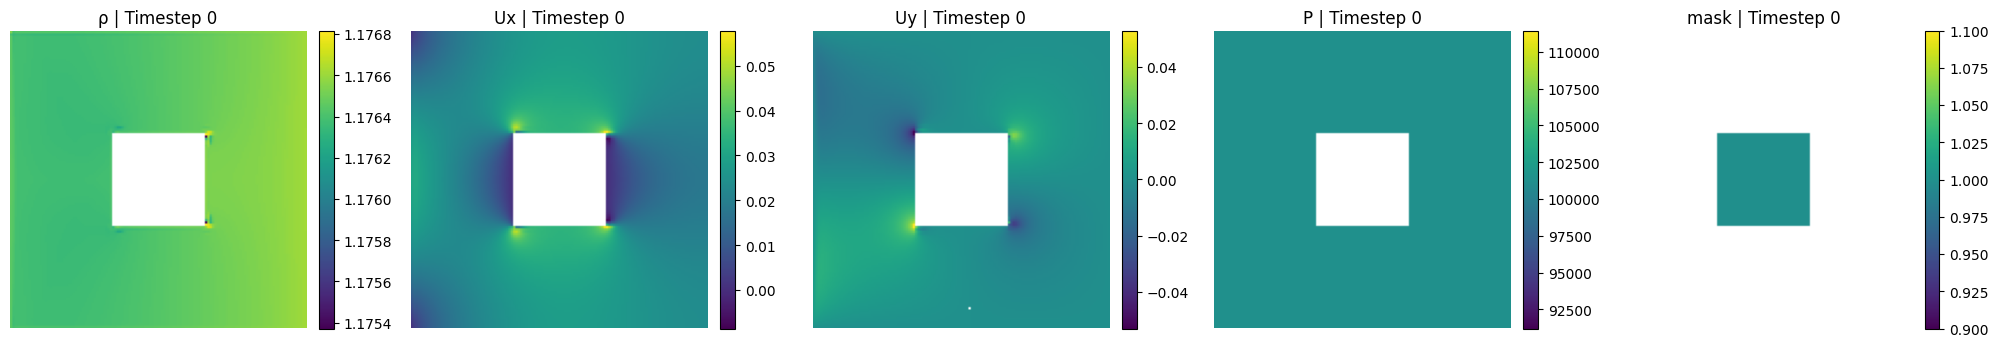

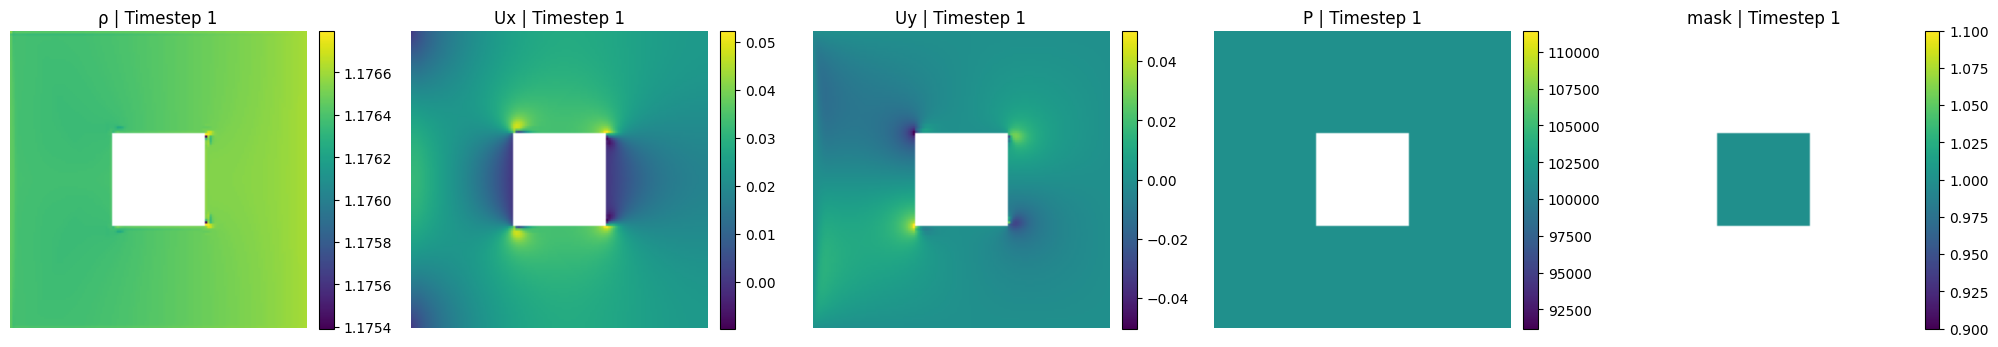

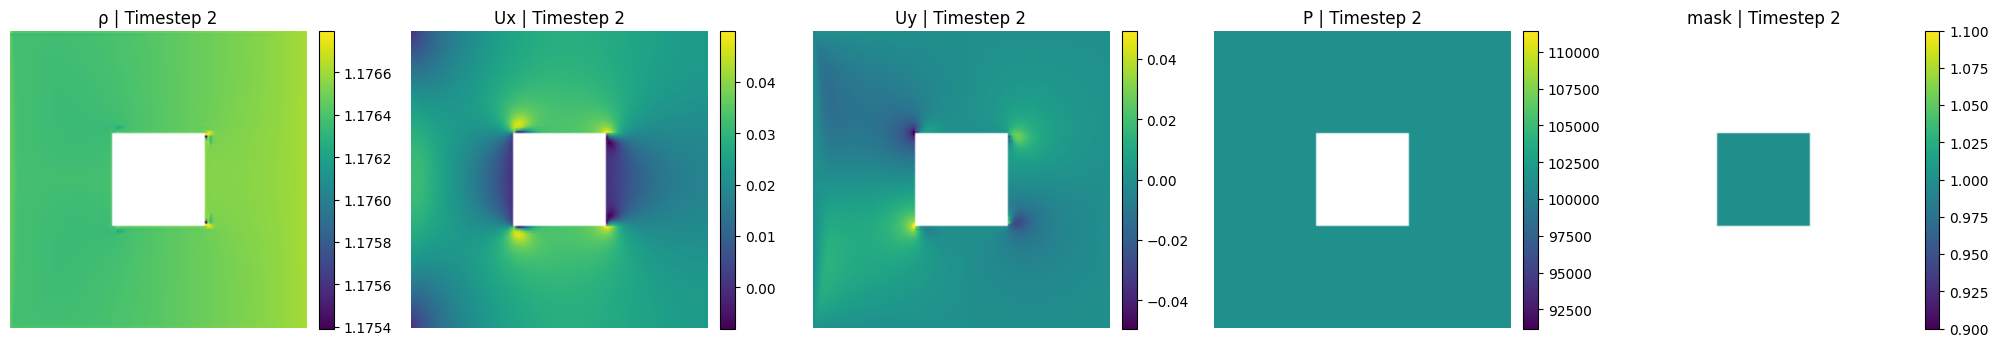

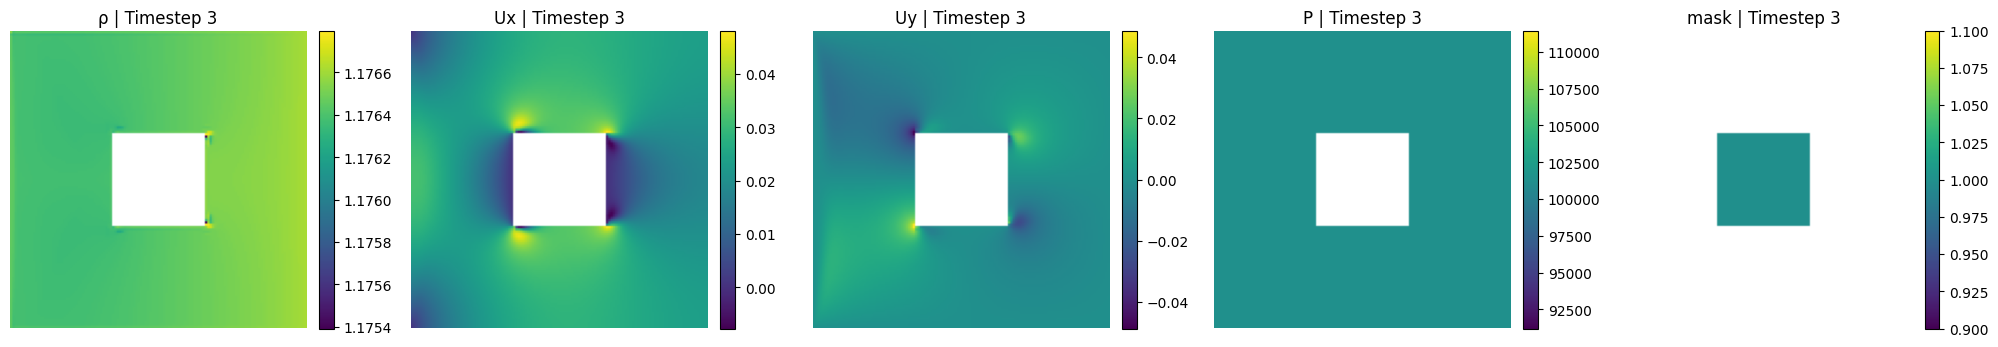

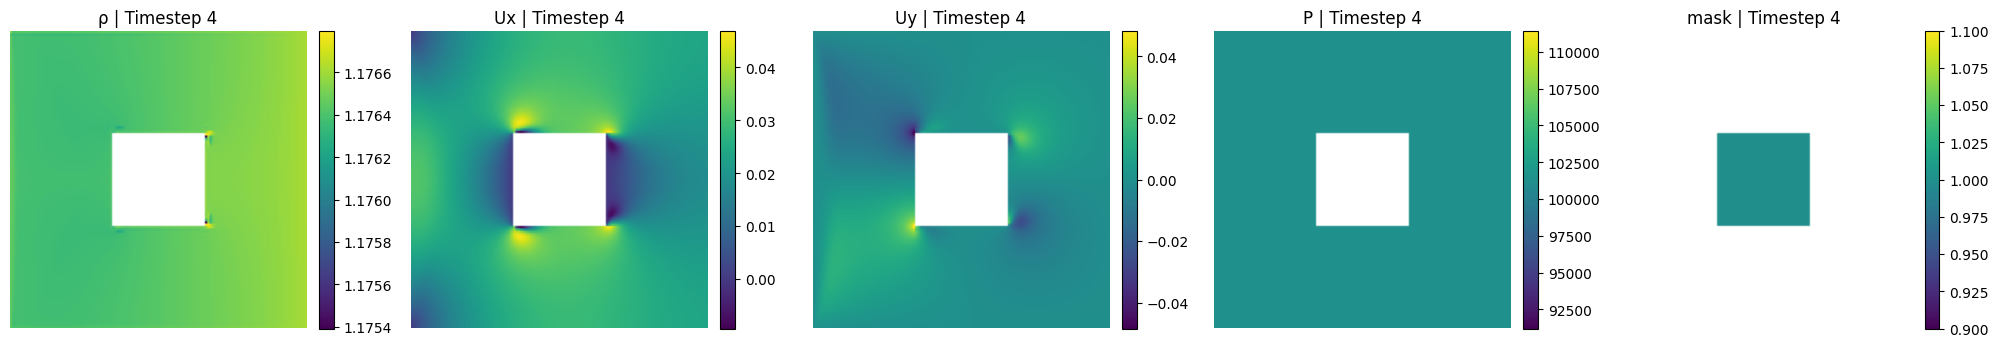

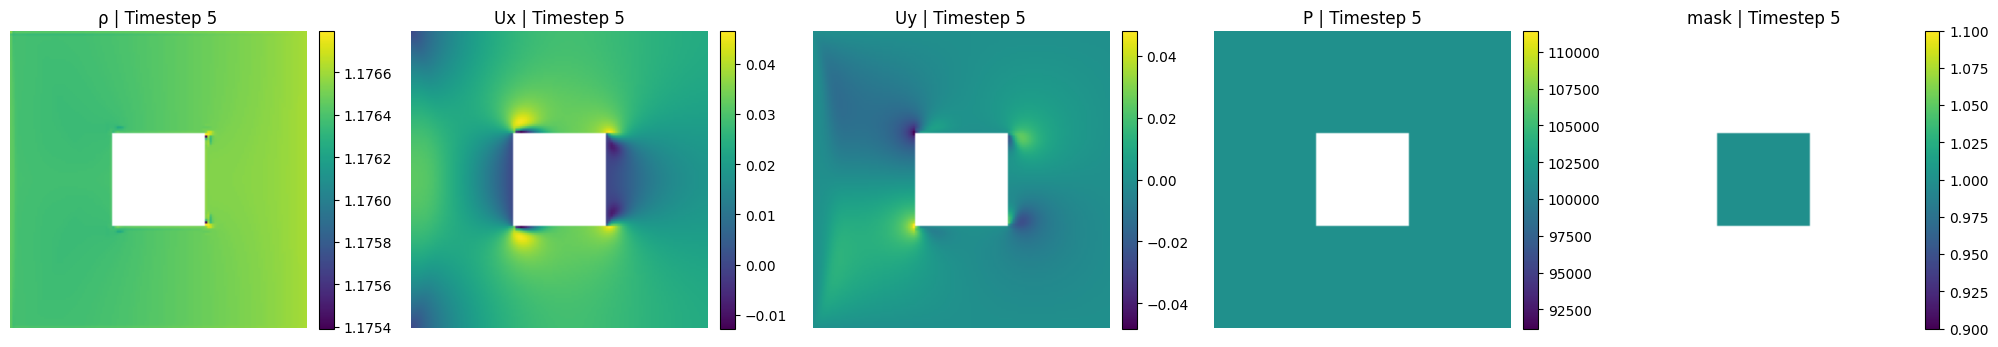

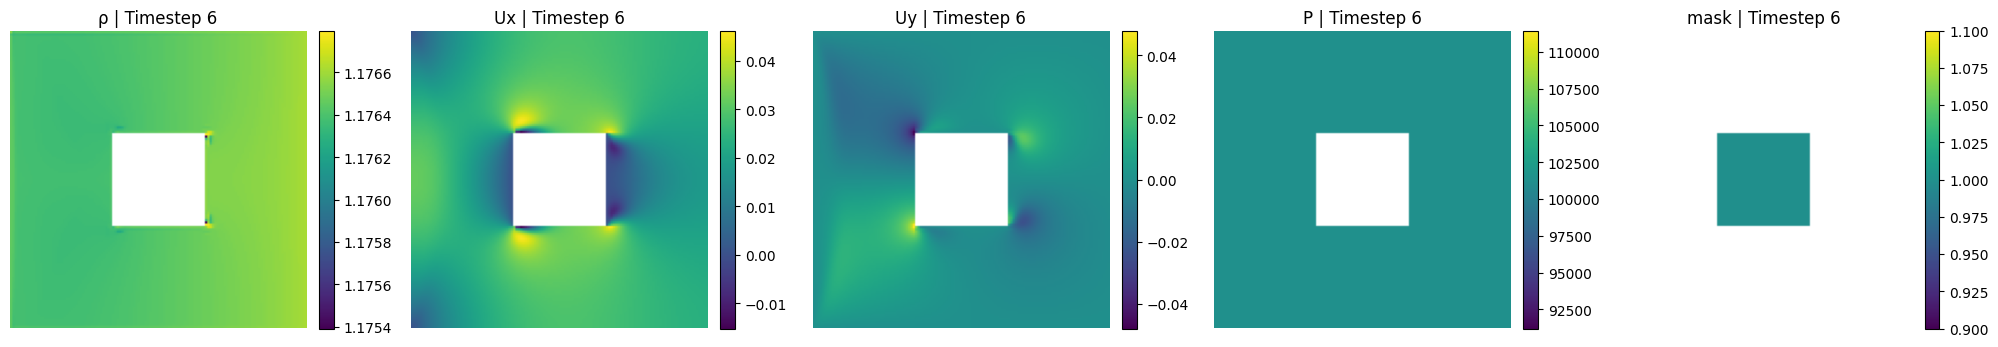

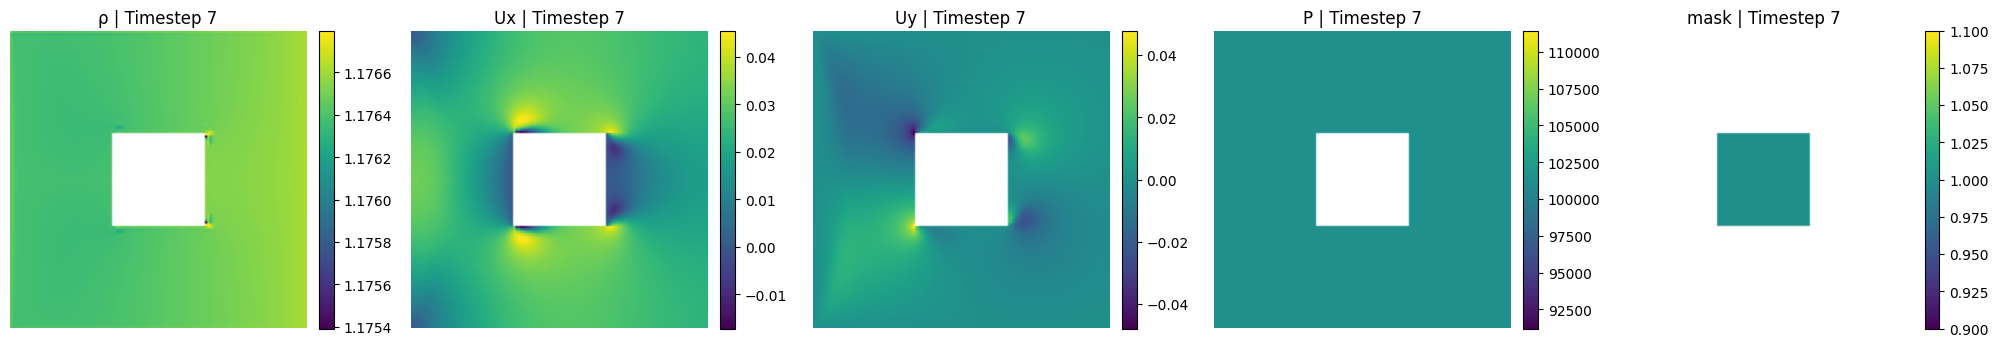

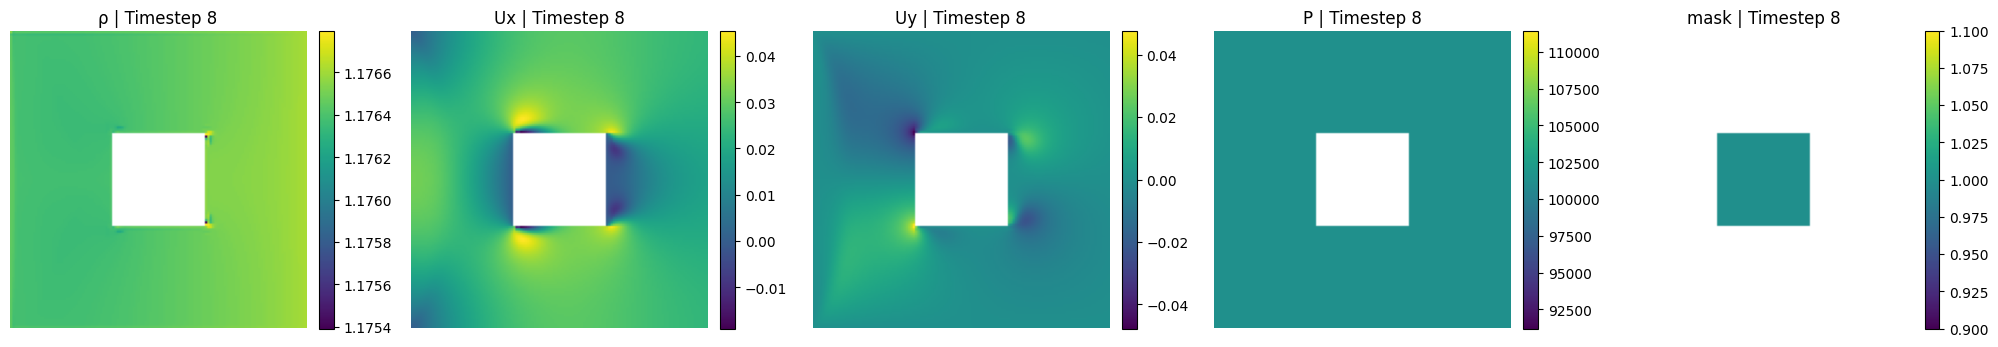

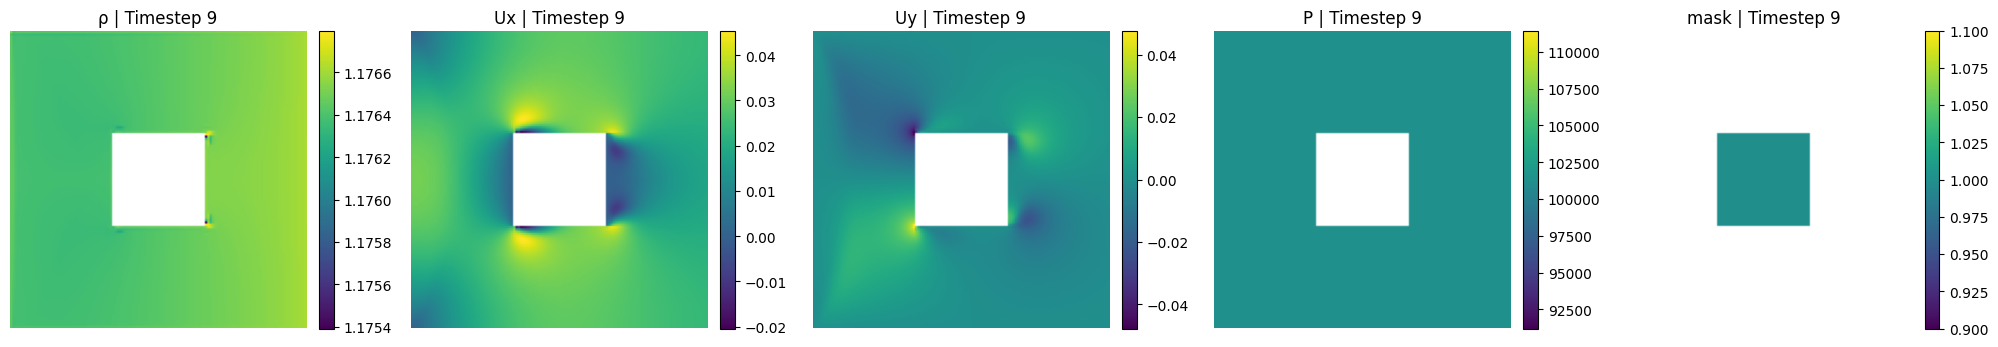

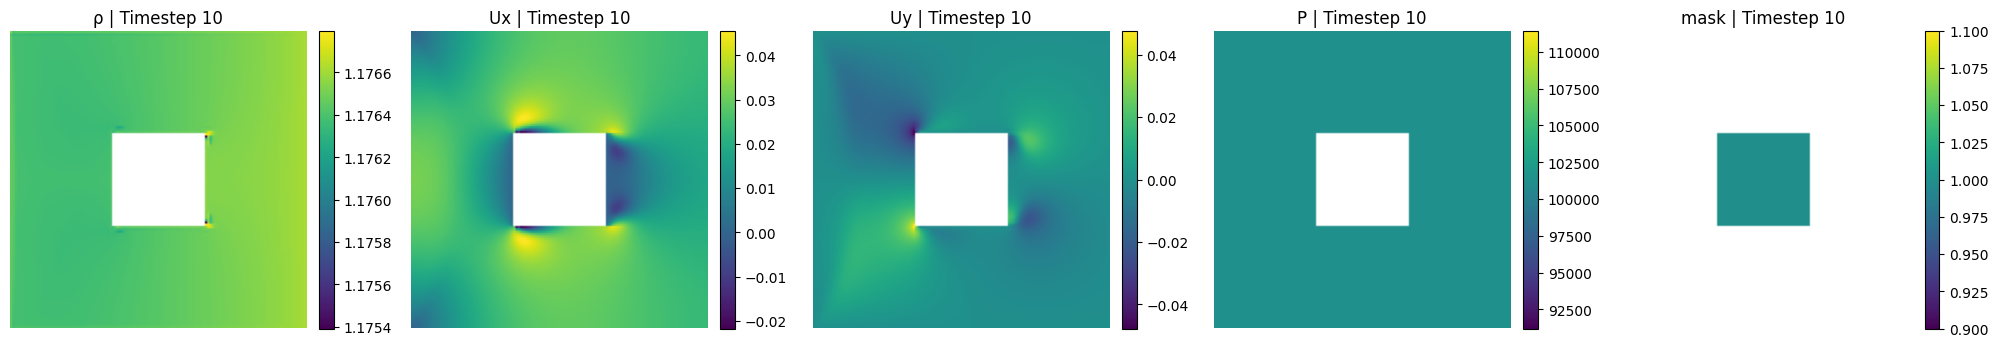

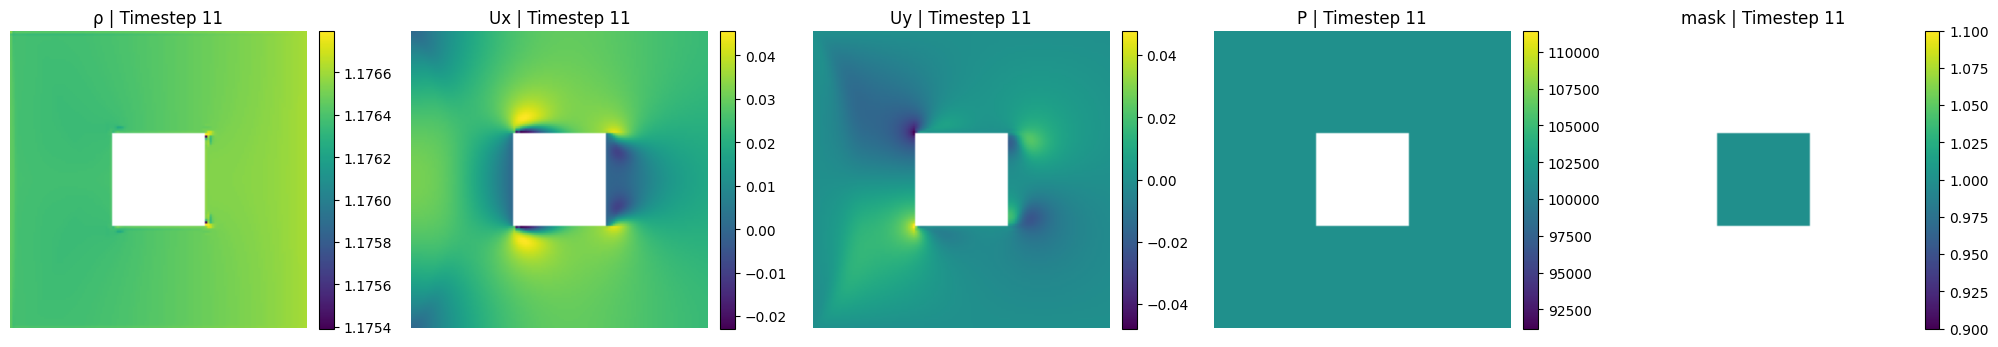

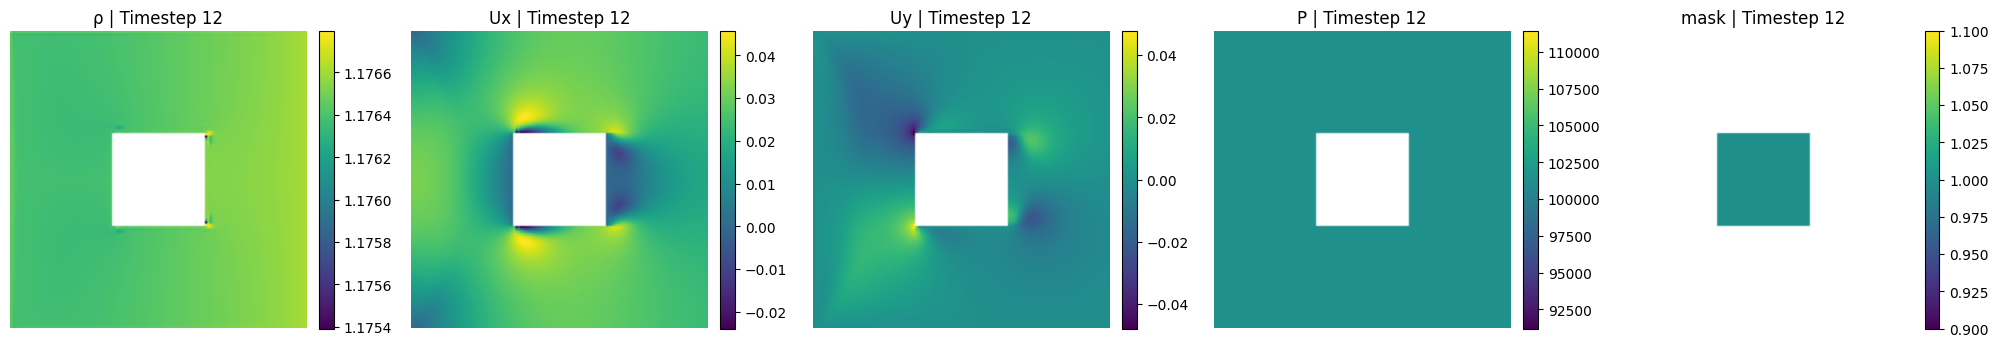

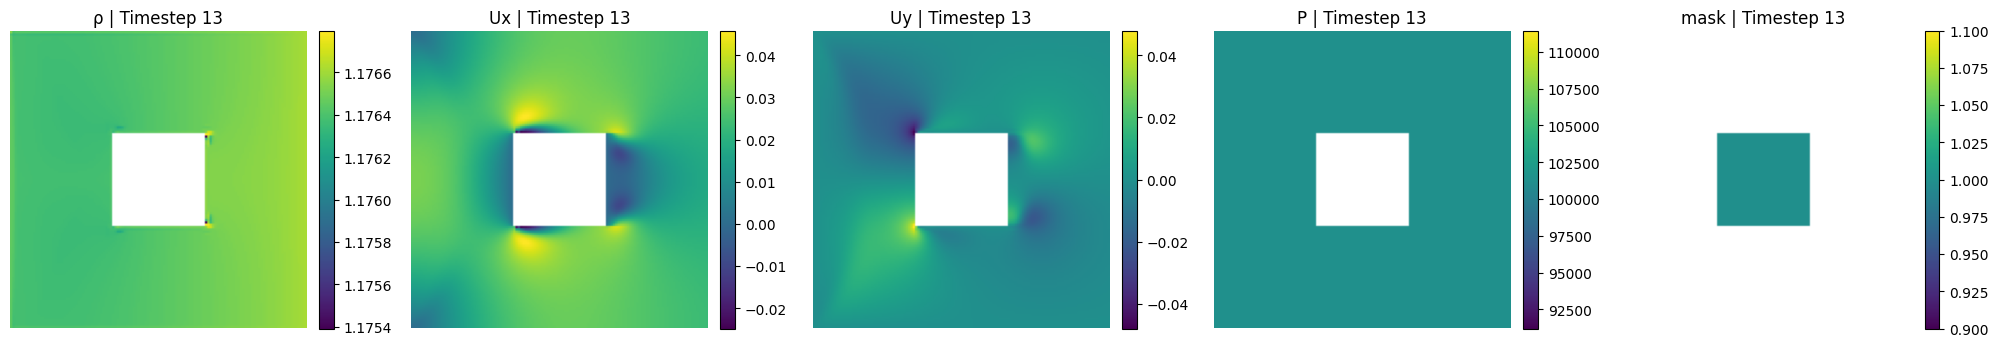

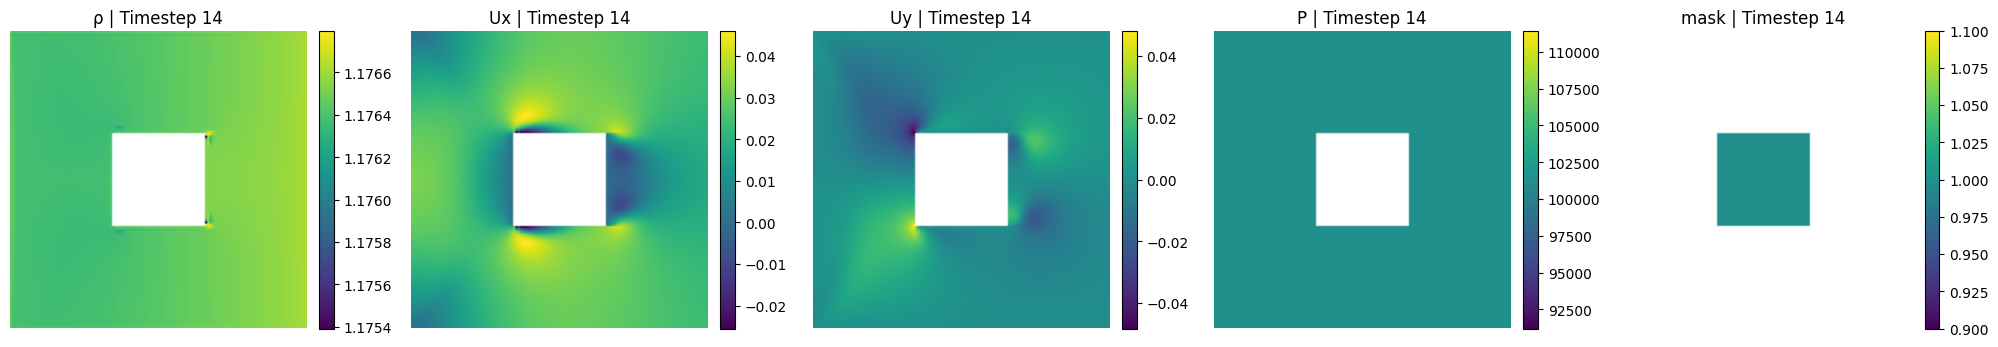

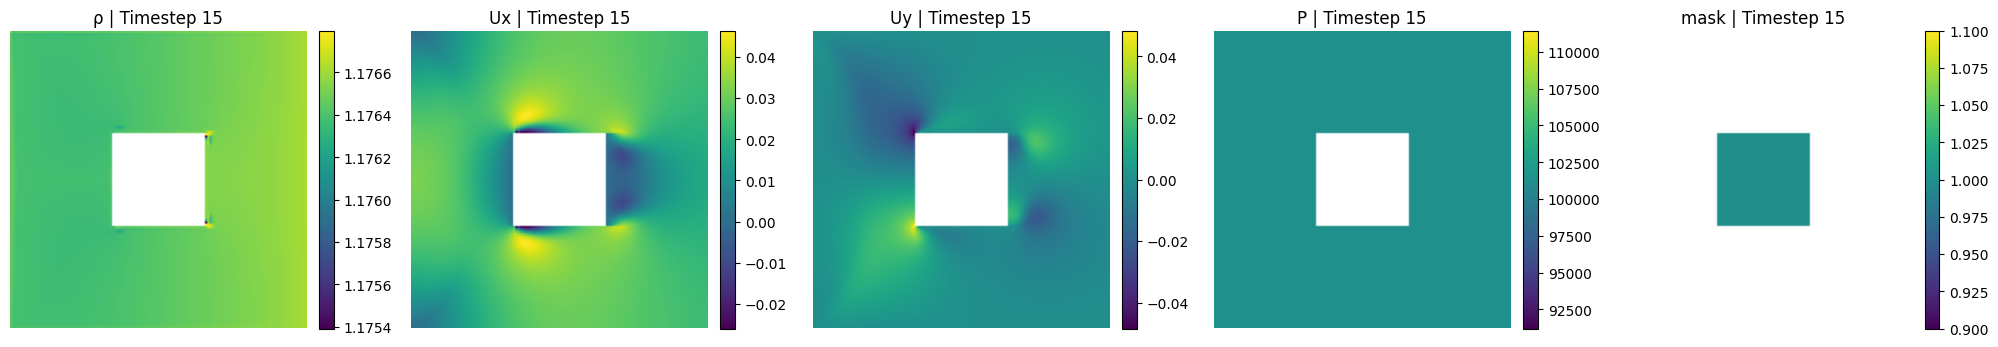

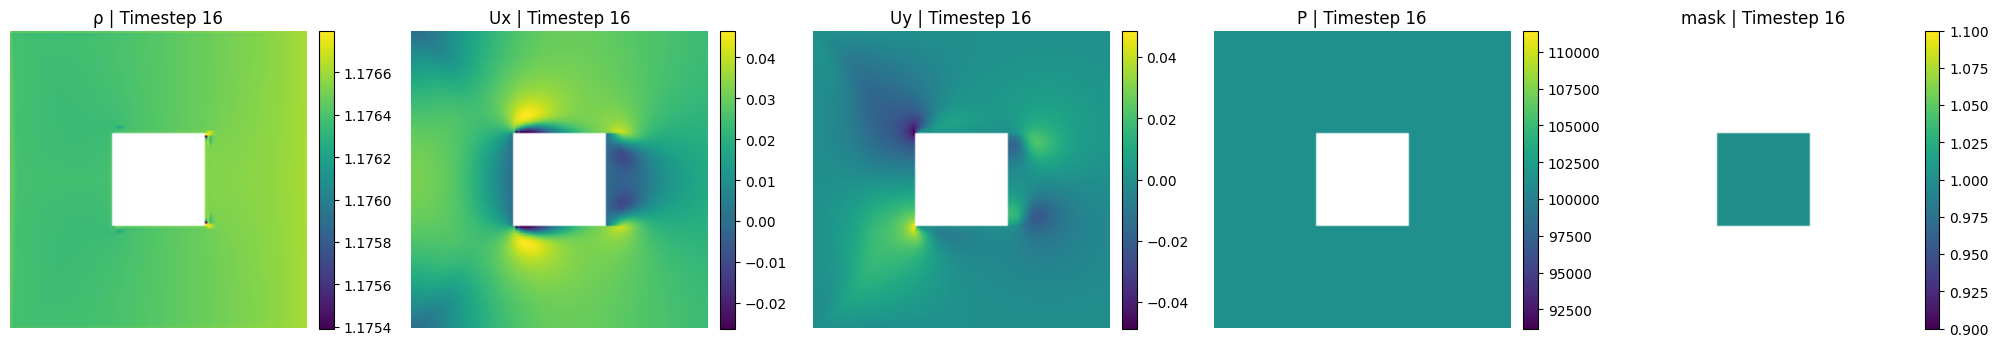

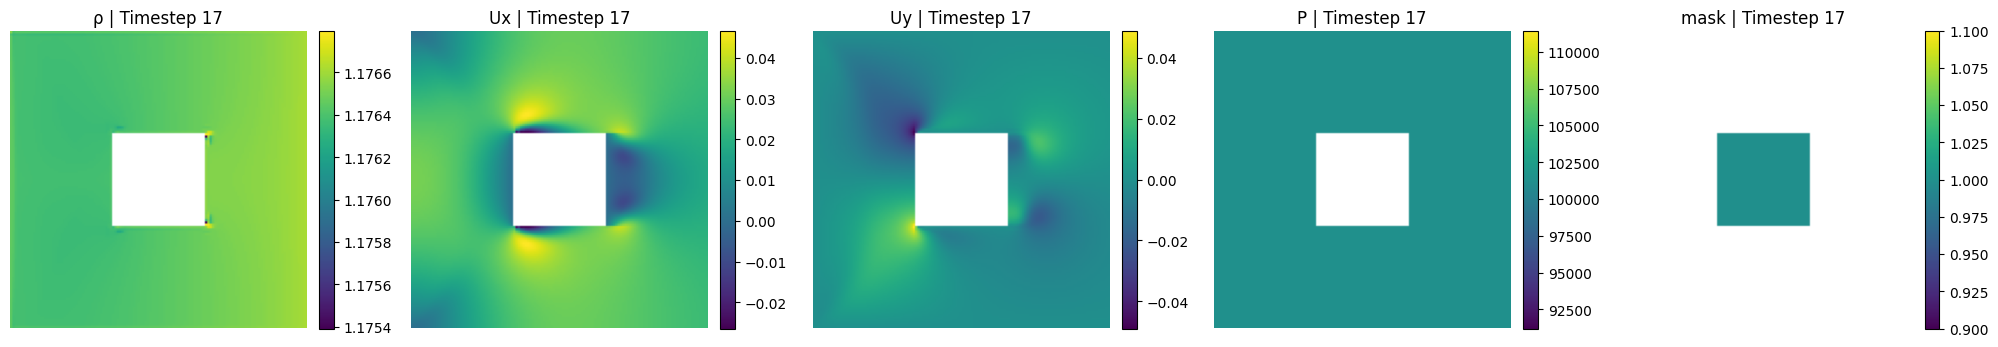

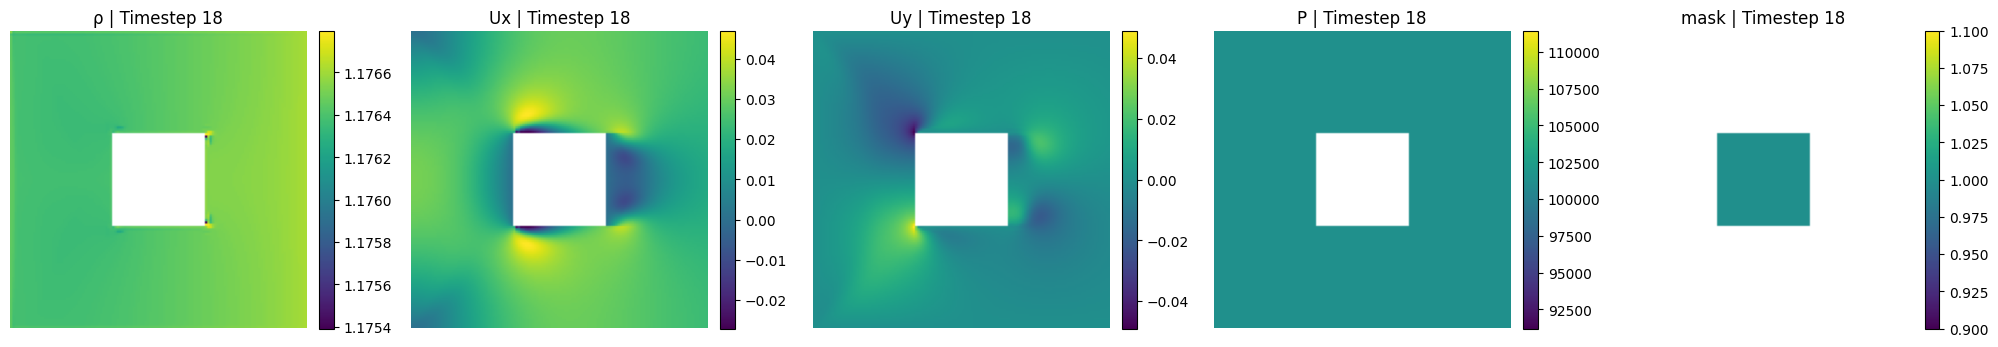

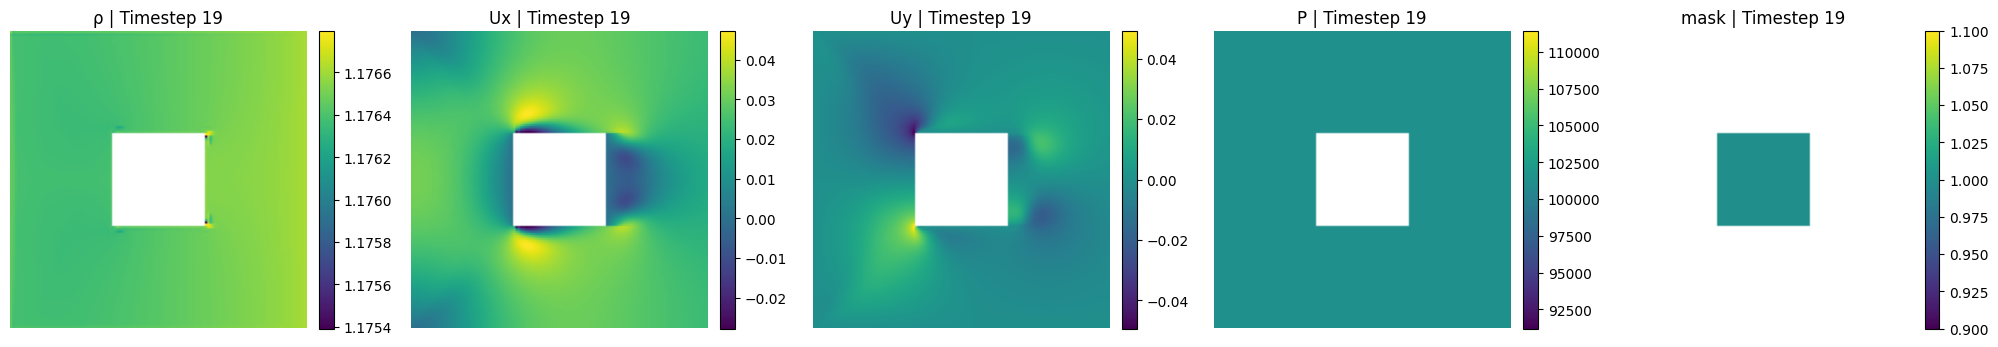

In [3]:
combined_data = np.load("/home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_cylinder/Hole_Size/all_sims_data_batch_0.npy")
sample_trajectory = combined_data[0]  # shape: (20,128,128,5)
# sample_timestep = 0
# plot_reshaped_sample(sample_trajectory, sample_timestep, output_folder)
plot_with_hole_white(
sample_trajectory, 
channel_names=["ρ", "Ux", "Uy", "P", "mask"], 
tol=1e-8
)

In [4]:
import numpy as np
import json
import logging

def parse_c_content(c_content):
    """
    Parse a string (from c_contents) to extract (x,y) coordinates.
    Expects the content to contain an 'internalField' entry.
    """
    lines = c_content.splitlines()
    start_idx = None
    num_centres = None
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the content")

    coordinates = []
    for line in lines[start_idx:start_idx+num_centres]:
        if "(" in line and ")" in line:
            # Assumes each line looks like "(x y z)"
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])
    return np.array(coordinates)

def add_coordinate_channels_reordered(reshaped, cell_centers):
    """
    Given a reshaped simulation array of shape (T, n_rows, n_cols, 5) where:
      - Channels 0-3: physical simulation data (e.g., ρ, Ux, Uy, P)
      - Channel 4: binary mask (hole indicator)
    
    This function adds two channels for x and y coordinates between the physical data
    and the binary mask. The final channel ordering will be:
       0-3: physical data, 
       4: x coordinate,
       5: y coordinate,
       6: binary mask.
    
    Parameters:
        reshaped (np.ndarray): Array of shape (T, n_rows, n_cols, 5)
        cell_centers (np.ndarray): Array of shape (num_cells, 2) containing (x,y) coordinates.
        
    Returns:
        enhanced (np.ndarray): Array of shape (T, n_rows, n_cols, 7)
    """
    T, n_rows, n_cols, channels = reshaped.shape
    if channels != 5:
        raise ValueError("Expected reshaped array to have 5 channels (4 physical + binary mask)")

    # Determine domain boundaries from cell centers
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])
    
    # Create empty grids for x and y coordinates; initialize with np.nan for holes.
    x_grid = np.full((n_rows, n_cols), np.nan)
    y_grid = np.full((n_rows, n_cols), np.nan)
    
    # Map each cell center to its grid index
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        x_grid[row, col] = x
        y_grid[row, col] = y

    # Tile the coordinate grids along the time axis to shape (T, n_rows, n_cols)
    x_grid_time = np.tile(x_grid, (T, 1, 1))
    y_grid_time = np.tile(y_grid, (T, 1, 1))
    
    # Separate the original reshaped data into physical data and binary mask.
    physical_data = reshaped[..., 0:4]   # shape (T, n_rows, n_cols, 4)
    original_mask = reshaped[..., 4:5]     # shape (T, n_rows, n_cols, 1)
    
    # Concatenate channels in the order: physical data, x, y, binary mask.
    enhanced = np.concatenate([
        physical_data,
        x_grid_time[..., np.newaxis],
        y_grid_time[..., np.newaxis],
        original_mask
    ], axis=-1)
    
    return enhanced

def test_enhanced_data(enhanced, original_reshaped, cell_centers):
    """
    Perform basic checks to ensure the enhanced data array is structured as expected.
    """
    T, n_rows, n_cols, channels = enhanced.shape
    if channels != 7:
        raise AssertionError(f"Expected 7 channels but got {channels}")
    
    # Check that physical data channels (0-3) match.
    if not np.allclose(enhanced[..., 0:4], original_reshaped[..., 0:4]):
        raise AssertionError("Mismatch in physical data channels.")
    
    # Check that the binary mask (channel 6) is preserved.
    if not np.allclose(enhanced[..., 6], original_reshaped[..., 4]):
        raise AssertionError("Binary mask does not match the original mask.")

    # Validate coordinate channels at a few grid locations.
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])
    
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        if not np.isclose(enhanced[0, row, col, 4], x):
            raise AssertionError(f"x coordinate mismatch at ({row}, {col}).")
        if not np.isclose(enhanced[0, row, col, 5], y):
            raise AssertionError(f"y coordinate mismatch at ({row}, {col}).")
    
    print("Enhanced data passed all basic integrity tests.")

# === MAIN PROCESSING CODE ===

# 1. Load the simulation npy file.
#    Assuming the file has shape (num_simulations, T, n_rows, n_cols, 5)
all_sim_data = np.load("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/FlowBench_Openfoam/Hole_Size/Hole_Size_384.npy")

# 2. Load the JSON file which is a list of simulation entries.
with open("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/FlowBench_Openfoam/Hole_Size/Hole_Size_384.json", "r") as f:
    sim_json = json.load(f)

# Check that the number of simulations matches.
if len(all_sim_data) != len(sim_json):
    raise ValueError("Number of simulations in the npy file does not match number of entries in the JSON file.")

enhanced_sim_list = []

# 3. Loop through each simulation and its corresponding JSON entry.
for i, sim_data in enumerate(all_sim_data):
    # Each JSON entry should have a "c_contents" key containing the cell centers as a string.
    entry = sim_json[i]
    c_contents = entry["c_contents"]
    
    # Parse the cell centers from the string.
    cell_centers = parse_c_content(c_contents)
    
    # Add the coordinate channels in the desired order.
    enhanced_sim = add_coordinate_channels_reordered(sim_data, cell_centers)
    
    # Optionally, run a test for the first timestep of this simulation.
    test_enhanced_data(enhanced_sim, sim_data, cell_centers)
    
    enhanced_sim_list.append(enhanced_sim)

# 4. Combine all enhanced simulations if needed.
# The final shape will be (num_simulations, T, n_rows, n_cols, 7)
enhanced_sim_data = np.array(enhanced_sim_list)

# 5. Save the enhanced simulation data.
np.save("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/FlowBench_Openfoam/Hole_Size/your_enhanced_simulation_file.npy", enhanced_sim_data)


ValueError: Number of simulations in the npy file does not match number of entries in the JSON file.